In [2]:
#| default_exp uode

In [1]:
#| hide 
%load_ext autoreload
%autoreload 2

In [2]:
#| export 

import torch 
import torch.nn as nn
from torchdiffeq import odeint as odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional
from pathlib import Path  

import pysindy as ps
from paramfittorchdemo.training import *

In [3]:
#| hide 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Using device: ", device)

Using device:  cpu


In [19]:
true_mu = 1.0
model_sim_vdp = VDP(mu=true_mu)
ts_data = torch.linspace(0.0,10.0,10) 
data_vdp = create_sim_dataset(model_sim_vdp, 
                              ts = ts_data, 
                              num_samples=30, 
                              sigma_noise=0.01)

In [23]:
#| export

class UniversalDiffEqVDP(nn.Module):
    """ 
    Basic Neural ODE model
    """
    def __init__(self,
                 dim: int = 2, # dimension of the state vector
                 mu: float = 0.9, # stiffness parameter of the VDP oscillator
                 ) -> None:
        super().__init__()
        self.ann = nn.Sequential(torch.nn.Linear(dim, 5), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(5, 5), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(5, dim))
        self.mu = torch.nn.Parameter(torch.tensor(mu)) # make mu a learnable parameter
        
    def forward(self, t, state):
        x = state[..., 0] # first dimension is the batch size
        y = state[..., 1]
        dX = self.mu*(x - y)
        dY = 1/self.mu*x
        # trick to make sure our return value has the same shape as the input
        dfunc = torch.zeros_like(state) 
        dfunc[..., 0] = dX
        dfunc[..., 1] = dY
        return dfunc + self.ann(state)

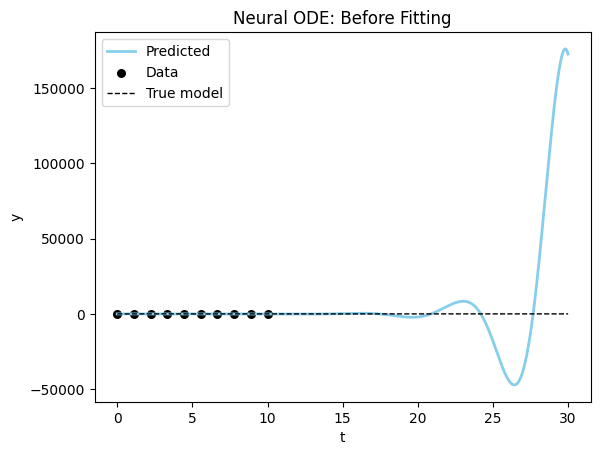

In [24]:
#|eval: false

model_vdp_uode = UniversalDiffEqVDP(dim=2) 
plot_time_series(model_sim_vdp, model_vdp_uode, data_vdp[0], title = "Neural ODE: Before Fitting");

In [42]:
#|eval: false

train(model_vdp_uode, 
      data_vdp, 
      epochs=50, 
      lr=1e-3, 
      batch_size=5,
      show_every=20,
      method = 'rk4',
      model_name = "uode")

Loss at 0: 0.03240423067472875
Loss at 20: 0.020343549665994942
Loss at 40: 0.018632547464221716


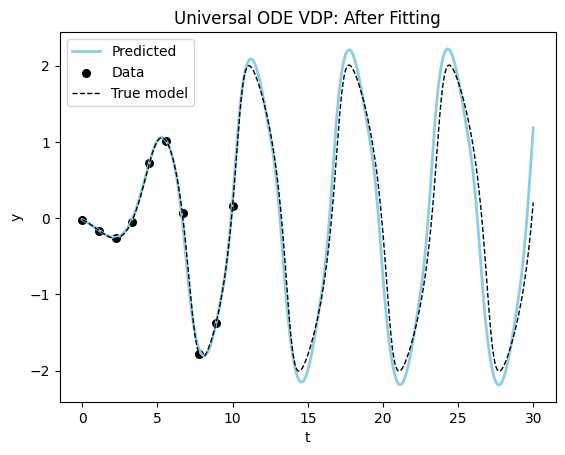

In [44]:
#|eval: false 

plot_time_series(model_sim_vdp, model_vdp_uode, data_vdp[0], title = "Universal ODE VDP: After Fitting", time_range=(0,30.0));

In [45]:
initial_state = torch.tensor([[0.10, 0.0]])
dt = 1e-4
ts = torch.arange(0.0, 10.0, dt)
x_train = odeint(model_vdp_uode, initial_state, ts, method='dopri8').transpose(0,1) 
x_train = x_train.detach().numpy().squeeze()

sindy_model = ps.SINDy(t_default=dt, feature_names=["x", "y"], feature_library=ps.PolynomialLibrary(degree=3), optimizer=ps.STLSQ(threshold=0.10))
sindy_model.fit(x_train, t=dt)
sindy_model.print()


(x)' = 0.966 x + -0.963 y + -0.338 x^3
(y)' = 1.011 x


## Lotka-Volterra equation example

Now let's make a universal ODE for the lotka-volterra example. 

In [16]:
class UniversalDiffEqLV(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 1.5, # The alpha parameter of the Lotka-Volterra system
                 delta: float = 3.0, # The beta parameter of the Lotka-Volterra system
                 dim: int = 2, # dimension of the state vector
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([alpha, delta]))
        
        # Neural network part
        self.ann = nn.Sequential(torch.nn.Linear(dim, 8), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(8, 16), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(16, 32), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(32, dim))
        
    def forward(self, t, state):
        x = state[...,0]      #variables are part of vector array u 
        y = state[...,1]
        sol = torch.zeros_like(state)
        
        #coefficients are part of tensor model_params
        alpha, delta = self.model_params    
        sol[...,0] = alpha*x 
        sol[...,1] = -delta*y 
        return sol + self.ann(state) 
    
    def __repr__(self):
        return f" alpha: {self.model_params[0].item()}, \
            beta: {self.model_params[1].item()}, "


In [24]:

model_sim_lv = LotkaVolterra(1.5,1.0,3.0,1.0)
ts_data = torch.arange(0.0, 10.0, 0.1)
data_lv = create_sim_dataset(model_sim_lv, 
                              ts = ts_data, 
                              num_samples=20, 
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([2.5, 2.5]))


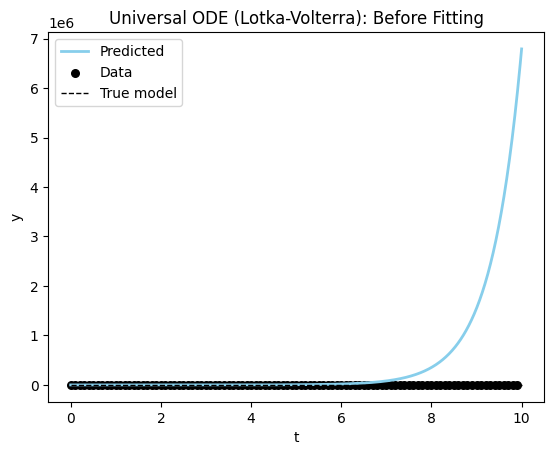

In [29]:
model_lv_uode = UniversalDiffEqLV(dim=2) 
plot_time_series(model_sim_lv, model_lv_uode, data_lv[0], title = "Universal ODE (Lotka-Volterra): Before Fitting", time_range=(0,10.0));

In [32]:
#|eval: false

train(model_lv_uode, 
      data_lv, 
      epochs=1000, 
      lr=1e-2, 
      batch_size=10,
      show_every=100,
      model_name = "uode")

Loss at 0: 36631973.0
Loss at 100: 126.27688217163086
Loss at 200: 126.48299407958984
Loss at 300: 126.48078536987305
Loss at 400: 126.54019165039062
Loss at 500: 126.41663360595703
Loss at 600: 126.14451599121094
Loss at 700: 126.55604553222656
Loss at 800: 126.10400772094727
Loss at 900: 126.30233001708984


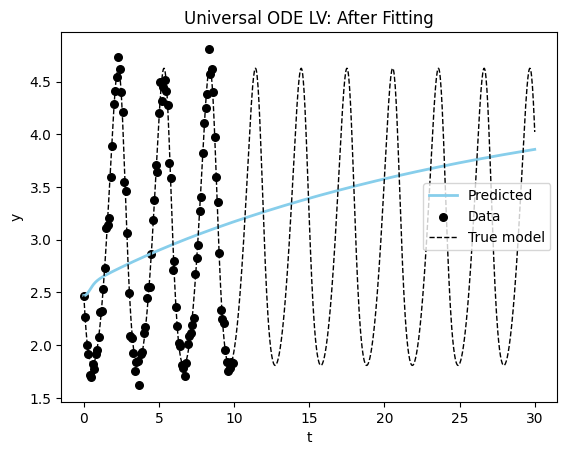

In [28]:
#|eval: false 

plot_time_series(model_sim_lv, model_lv_uode, data_lv[0], title = "Universal ODE LV: After Fitting", time_range=(0,30.0));

Now we can actually take this analysis further by trying to recover the actual polynomial terms from the universal ode. This involves making use of a tool called SINDy (Sparse Identification of Nonlinear Dynamics). This is a tool that can be used to recover the underlying dynamics of a system from data. Typically, it requires data which is pretty dense in time, but we can use it here to recover the dynamics from the universal ode since we can sample from our universal ode as densely as we want. 

Let's see if we can recover the actual underlying equations from the universal ode.



In [ ]:
#| hide

import nbdev; nbdev.nbdev_export()